# Exploring Gaussian Processes
### Yabra Muvdi

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Gaussian Processes

### 1.1. Squared Exponential (SE) Kernel

In [2]:
def se_kernel(x, y, l, sigma_f, sigma_n):
    """ a function to calculate the Squared Exponential Kernel
    """
    
    dist2 = np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)
    
    # calculate Kroeneker delta
    kroneker_delta = 0
    try:
        if np.linalg.norm(x-y) == 0:
            kroneker_delta = 1
    except:
        kroneker_delta = 0
    
    return (sigma_f**2)*( np.exp( -(0.5*dist2)/(l**2) ) ) + (sigma_n**2)*kroneker_delta

In [3]:
# 100 test points
n = 100
X = np.linspace(-7,7,n).reshape(-1,1)
cov = se_kernel(X, X, l=1, sigma_f=1, sigma_n=0.1)

# assuming mean zero for the GP
mu = [0]*n

In [4]:
# draw 5 sample functions based on the GP
prior_values = np.random.multivariate_normal(mu,cov,5).reshape(-1,1)

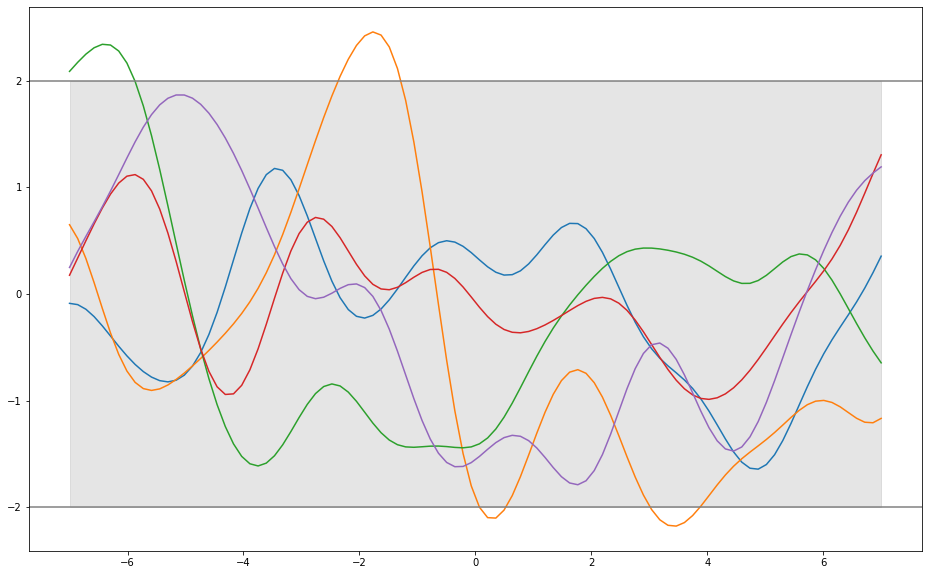

In [5]:
plt.figure(figsize=(16,10))

# plot the functions drawn from the prior distribution
plt.plot(X, prior_values[0:100])
plt.plot(X, prior_values[100:200])
plt.plot(X, prior_values[200:300])
plt.plot(X, prior_values[300:400])
plt.plot(X, prior_values[400:500])

# plot confidence intervals
plt.axhline(y=2, color='grey')
plt.axhline(y=-2, color='grey')
plt.fill_between(X.flatten(),2,-2, color='grey', alpha=0.2)

plt.show()

### 1.2. GP Posterior

In [6]:
def posterior(X_train, y_train, X_test, l, sigma_f, sigma_n):
    """ a function to implement the algorithm 2.1. described
        in Rasmussen & Williams (2016) to update hyperparameters
        of a GP according to new data observed
        
    """
    
    K = se_kernel(X_train, X_train, l=l, sigma_f=sigma_f, sigma_n=sigma_n)
    L = np.linalg.cholesky(K + 1e-6*np.eye(X_train.shape[0]))
    l_y, resid, rank, s  = np.linalg.lstsq(L, y_train, rcond = None)
    alpha, resid, rank, s = np.linalg.lstsq(L.T, l_y, rcond = None) 
    K_star = se_kernel(X_train, X_test, l=l, sigma_f=sigma_f, sigma_n=sigma_n)
    v, resid, rank, s = np.linalg.lstsq(L,K_star, rcond = None)
    
    # calculate the updated mean
    f_mean = np.dot(K_star.T, alpha)
    
    # calculate the updated variance
    f_var = se_kernel(X_test, X_test, l=l, sigma_f=sigma_f, sigma_n=sigma_n) - np.dot(v.T,v)
    
    return(f_mean,f_var)

In [7]:
# generate training data from a uniform distribution
n = 20
X_train = np.random.uniform(-7,7,n).reshape(-1,1)
cov = se_kernel(X_train, X_train, l=1, sigma_f=1, sigma_n=0.1)
# assuming mean zero for the GP
mu = [0]*n
# draw one sample function to get the values
y_train = np.random.multivariate_normal(mu,cov,1).reshape(-1,1)

In [8]:
# generate test data
X_test = np.linspace(-7,7,100).reshape(-1,1)

In [9]:
# compute posterior
post_mean, post_var = posterior(X_train, y_train, X_test, 1, 1, 0.1)

In [10]:
# calculate the standard deviation
std = np.sqrt(np.diagonal(post_var))

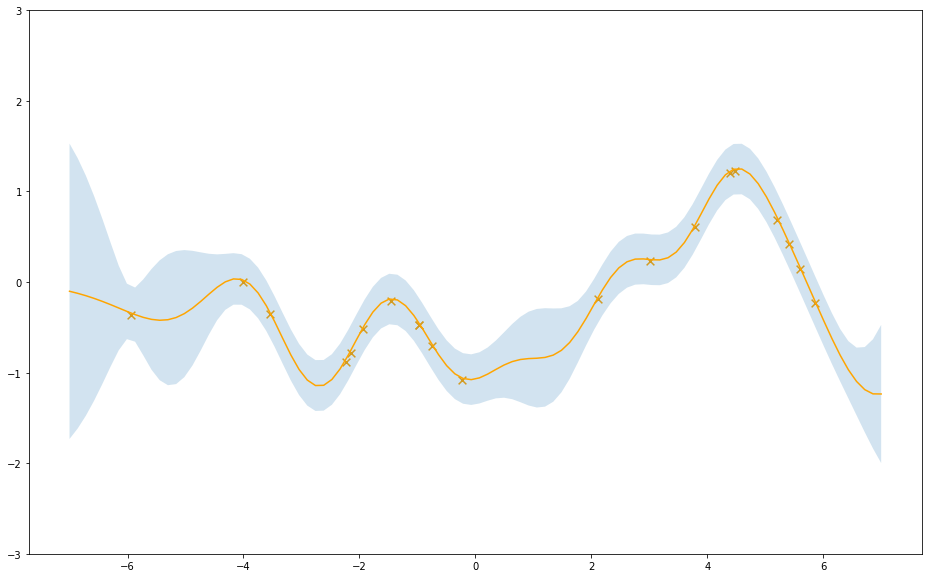

In [11]:
# test plot
plt.figure(figsize=(16,10))

plt.scatter(X_train, y_train, marker = "x", s = 60, c = 'orange')
plt.fill_between(list(X_test.flatten()), 
                 list(post_mean.flatten()-(2*std)), 
                 list(post_mean.flatten()+(2*std)),
                 alpha = 0.2
                )
plt.plot(X_test, post_mean, color = 'orange')
plt.ylim((-3,3))

plt.show()

## 1.3 Figure replication

In [70]:
# generate test data
X_test = np.linspace(-7,7,100).reshape(-1,1)

# generate training data from a uniform distribution
n = 20
X_train = np.random.uniform(-7,7,n).reshape(-1,1)

# assuming mean zero for all the GP
mu = [0]*n

# PLOT 1 DATA
cov = se_kernel(X_train, X_train, l=1, sigma_f=1, sigma_n=0.1)
y_train = np.random.multivariate_normal(mu,cov,1).reshape(-1,1)

# compute posteriors for the first set of parameters
post_mean1, post_var1 = posterior(X_train, y_train, X_test, 1, 1, 0.1)
# calculate the standard deviation
std1 = np.sqrt(np.diagonal(post_var1))

# PLOT 2 DATA

# compute posteriors for the first set of parameters
post_mean2, post_var2 = posterior(X_train, y_train, X_test, 0.3, 1.08, 0.00005)
# calculate the standard deviation
std2 = np.sqrt(np.diagonal(post_var2))

# PLOT 3 DATA

# compute posteriors for the first set of parameters
post_mean3, post_var3 = posterior(X_train, y_train, X_test, 3, 1.16, 0.89)
# calculate the standard deviation
std3 = np.sqrt(np.diagonal(post_var3))

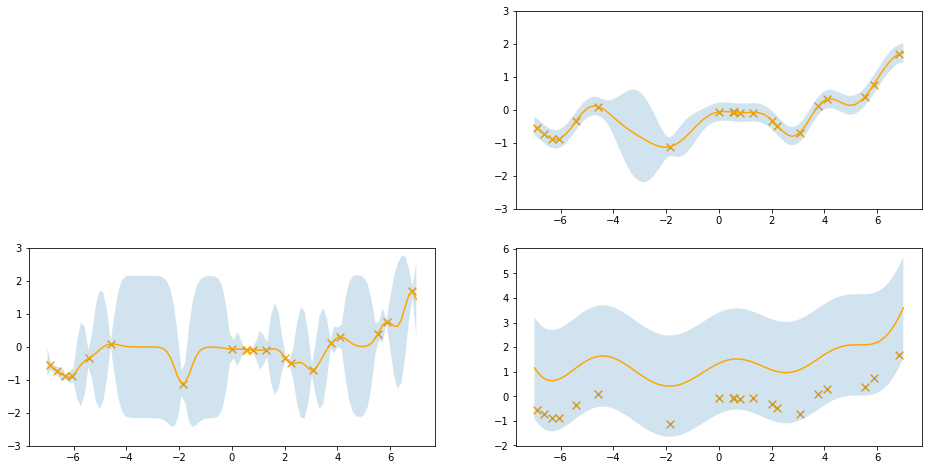

In [71]:
# plotting all of them together
f, axs = plt.subplots(2, 2, figsize=(16,8))

# blank plot
axs[0, 0].axis('off')

# PLOT 1
axs[0,1].scatter(X_train, y_train, marker = "x", s = 60, c = 'orange')
axs[0,1].fill_between(list(X_test.flatten()), 
                 list(post_mean1.flatten()-(2*std1)), 
                 list(post_mean1.flatten()+(2*std1)),
                 alpha = 0.2
                )
axs[0,1].plot(X_test, post_mean1, color = 'orange')
axs[0,1].set_ylim((-3,3))


# PLOT 2
axs[1,0].scatter(X_train, y_train, marker = "x", s = 60, c = 'orange')
axs[1,0].fill_between(list(X_test.flatten()), 
                 list(post_mean2.flatten()-(2*std2)), 
                 list(post_mean2.flatten()+(2*std2)),
                 alpha = 0.2
                )
axs[1,0].plot(X_test, post_mean2, color = 'orange')
axs[1,0].set_ylim((-3,3))

# PLOT 3
axs[1,1].scatter(X_train, y_train, marker = "x", s = 60, c = 'orange')
axs[1,1].fill_between(list(X_test.flatten()), 
                 list(post_mean3.flatten()-(2*std3)), 
                 list(post_mean3.flatten()+(2*std3)),
                 alpha = 0.2
                )
axs[1,1].plot(X_test, post_mean3, color = 'orange')



plt.show()

## 2. Bayesian Optimization

### 2.1. Branin-Hoo function

In [72]:
from mpl_toolkits import mplot3d

In [73]:
def branin_hoo(x, 
               a=1, 
               b=(5.1/(4*np.pi**2)), 
               c=5/np.pi, 
               r=6, 
               s=10, 
               t=1/(8*np.pi)):
    
    result = (a*(x[1] - (b*x[0]**2) + (c*x[0]) - r)**2 
             + s*(1-t)*np.cos(x[0]) 
             + s)

    return result

In [74]:
# verify that the function is correctly implemented
min_x1 = np.array([-np.pi, 12.275])
min_x2 = np.array([np.pi, 2.275])
min_x3 = np.array([9.42478, 2.475])

In [75]:
print(branin_hoo(min_x1))
print(branin_hoo(min_x2))
print(branin_hoo(min_x3))

0.39788735772973816
0.39788735772973816
0.39788735775266204


In [76]:
# Define the square
X = np.zeros((50,50,2))

for i,x1 in enumerate(np.linspace(10,15,50)):
    for j,x2 in enumerate(np.linspace(-5,0,50)):
        X[i,j] = [x2,x1]

In [78]:
zdata = [branin_hoo(pair) for row in X for pair in row]
xdata = [pair[0] for row in X for pair in row]
ydata = [pair[1] for row in X for pair in row]

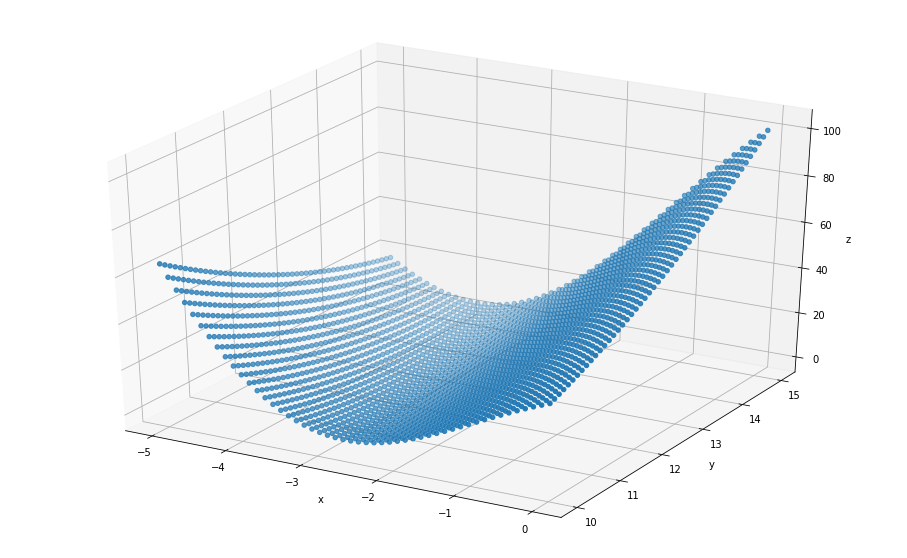

In [79]:
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')

ax.scatter3D(xdata, ydata, z)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### 2.2. UCB

In [133]:
def UCB(X, X_sample, gpr, epsilon, t):
    
    mu, sigma = gpr.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    dim = X.shape[1]
    delta = epsilon
    beta = np.sqrt( (2*np.log(((np.pi**2)*(t**(dim/4)))/(3*delta))) )
    
    return(mu + beta*sigma)

### 2.3. Probaility of Improvement (PI)

In [134]:
from scipy.stats import norm

In [135]:
def PI(X, X_sample, gpr, epsilon, t):

    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    sigma = sigma.reshape(-1, 1)
    mu_sample_opt = np.max(mu_sample)
    Z = ((mu - mu_sample_opt - epsilon)/sigma)
    pi = norm.cdf(Z)

    return(pi)

### 2.4. Expected Improvement (EI)

In [136]:
def EI(X, X_sample, gpr, epsilon, t):

    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - epsilon
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

### 2.5. How to pick the next point to sample?

In [137]:
from scipy.optimize import minimize

def next_point(acquisition, X_sample, Y_sample, gpr, epsilon, t, bounds, n_restarts=25):

    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, gpr, epsilon, t)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x

### 2.6. Optimize

In [138]:
# we know the min of the function
optimal_min = branin_hoo(min_x1) 

In [139]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [195]:
# 1. UCB DATA

# GP definition using sklearn
my_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=my_kernel, alpha=0.15)

# define the bounds of the square
bounds = np.array([[-5, 10],[0,15]])

# Initialize samples
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(2, 2))
Y_sample = branin_hoo(X_sample)

# Number of iterations
n_iter = 98

# save the squared error at each iteration
squared_error_ucb1 = []
for i in range(n_iter):
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = next_point(UCB, X_sample, Y_sample, gpr, 0.3, i+2, bounds)
    
    # Obtain next sample from the objective function
    Y_next = branin_hoo(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # get the best achieved value (min)
    current_min = np.min(Y_sample)
    
    # Calcualte the squared error
    squared_error_ucb1.append((current_min - optimal_min)**2)
               
# clean the GP
my_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=my_kernel, alpha=0)

# Initialize samples
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(2, 2))
Y_sample = branin_hoo(X_sample)

# save the squared error at each iteration
squared_error_ucb2 = []
for i in range(n_iter):
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = next_point(UCB, X_sample, Y_sample, gpr, 0.1, i+2, bounds)
    
    # Obtain next sample from the objective function
    Y_next = branin_hoo(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # get the best achieved value (min)
    current_min = np.min(Y_sample)
    
    # Calcualte the squared error
    squared_error_ucb2.append((current_min - optimal_min)**2)
    
    
# clean the GP
my_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=my_kernel, alpha=0)

# Initialize samples
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(2, 2))
Y_sample = branin_hoo(X_sample)

# save the squared error at each iteration
squared_error_ucb3 = []
for i in range(n_iter):
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = next_point(UCB, X_sample, Y_sample, gpr, 0.05, i+2, bounds)
    
    # Obtain next sample from the objective function
    Y_next = branin_hoo(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # get the best achieved value (min)
    current_min = np.min(Y_sample)
    
    # Calcualte the squared error
    squared_error_ucb3.append((current_min - optimal_min)**2)

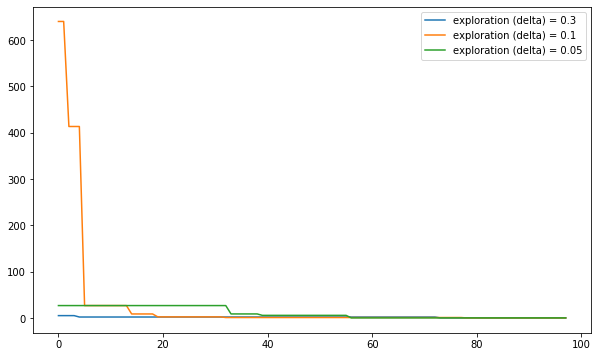

In [196]:
fig = plt.figure(figsize=(10,6))

plt.plot(list(range(n_iter)), squared_error_ucb1, label='exploration (delta) = 0.3')
plt.plot(list(range(n_iter)), squared_error_ucb2, label='exploration (delta) = 0.1')
plt.plot(list(range(n_iter)), squared_error_ucb3, label='exploration (delta) = 0.05')

plt.legend()
plt.show()

In [189]:
# 2. EXPECTED IMPROVEMENT DATA

# GP definition using sklearn
my_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=my_kernel, alpha=0)

# define the bounds of the square
bounds = np.array([[-5, 10],[0,15]])

# Initialize samples
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(2, 2))
Y_sample = branin_hoo(X_sample)

# Number of iterations
n_iter = 98

# save the squared error at each iteration
squared_error_ei1 = []
for i in range(n_iter):
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = next_point(EI, X_sample, Y_sample, gpr, 0.1, i+2, bounds)
    
    # Obtain next sample from the objective function
    Y_next = branin_hoo(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # get the best achieved value (min)
    current_min = np.min(Y_sample)
    
    # Calcualte the squared error
    squared_error_ei1.append((current_min - optimal_min)**2)

# clean the GP
my_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=my_kernel, alpha=0)

# Initialize samples
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(2, 2))
Y_sample = branin_hoo(X_sample)    

# save the squared error at each iteration
squared_error_ei2 = []
for i in range(n_iter):
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = next_point(EI, X_sample, Y_sample, gpr, 0.01, i+2, bounds)
    
    # Obtain next sample from the objective function
    Y_next = branin_hoo(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # get the best achieved value (min)
    current_min = np.min(Y_sample)
    
    # Calcualte the squared error
    squared_error_ei2.append((current_min - optimal_min)**2)
  

# clean the GP
my_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=my_kernel, alpha=0)

# Initialize samples
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(2, 2))
Y_sample = branin_hoo(X_sample)

# save the squared error at each iteration
squared_error_ei3 = []
for i in range(n_iter):
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = next_point(EI, X_sample, Y_sample, gpr, 0.001, i+2, bounds)
    
    # Obtain next sample from the objective function
    Y_next = branin_hoo(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # get the best achieved value (min)
    current_min = np.min(Y_sample)
    
    # Calcualte the squared error
    squared_error_ei3.append((current_min - optimal_min)**2)

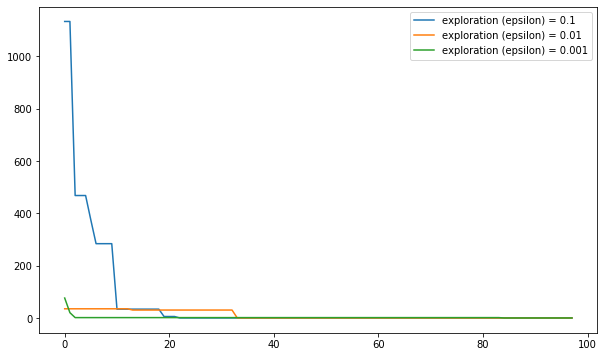

In [190]:
fig = plt.figure(figsize=(10,6))

plt.plot(list(range(n_iter)), squared_error_ei1, label='exploration (epsilon) = 0.1')
plt.plot(list(range(n_iter)), squared_error_ei2, label='exploration (epsilon) = 0.01')
plt.plot(list(range(n_iter)), squared_error_ei3, label='exploration (epsilon) = 0.001')

plt.legend()
plt.show()

In [184]:
# 3. PROBABILITY IMPROVEMENT DATA

# GP definition using sklearn
my_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=my_kernel, alpha=0)

# define the bounds of the square
bounds = np.array([[-5, 10],[0,15]])

# Initialize samples
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(2, 2))
Y_sample = branin_hoo(X_sample)

# Number of iterations
n_iter = 98

# save the squared error at each iteration
squared_error_pi1 = []
for i in range(n_iter):
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = next_point(PI, X_sample, Y_sample, gpr, 0.1, i+2, bounds)
    
    # Obtain next sample from the objective function
    Y_next = branin_hoo(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # get the best achieved value (min)
    current_min = np.min(Y_sample)
    
    # Calcualte the squared error
    squared_error_pi1.append((current_min - optimal_min)**2)
    

# clean the GP
my_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=my_kernel, alpha=0)

# Initialize samples
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(2, 2))
Y_sample = branin_hoo(X_sample)

# save the squared error at each iteration
squared_error_pi2 = []
for i in range(n_iter):
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = next_point(PI, X_sample, Y_sample, gpr, 0.01, i+2, bounds)
    
    # Obtain next sample from the objective function
    Y_next = branin_hoo(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # get the best achieved value (min)
    current_min = np.min(Y_sample)
    
    # Calcualte the squared error
    squared_error_pi2.append((current_min - optimal_min)**2)

    
# clean the GP
my_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=my_kernel, alpha=0)

# Initialize samples
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(2, 2))
Y_sample = branin_hoo(X_sample)

# save the squared error at each iteration
squared_error_pi3 = []
for i in range(n_iter):
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = next_point(PI, X_sample, Y_sample, gpr, 0.001, i+2, bounds)
    
    # Obtain next sample from the objective function
    Y_next = branin_hoo(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # get the best achieved value (min)
    current_min = np.min(Y_sample)
    
    # Calcualte the squared error
    squared_error_pi3.append((current_min - optimal_min)**2)

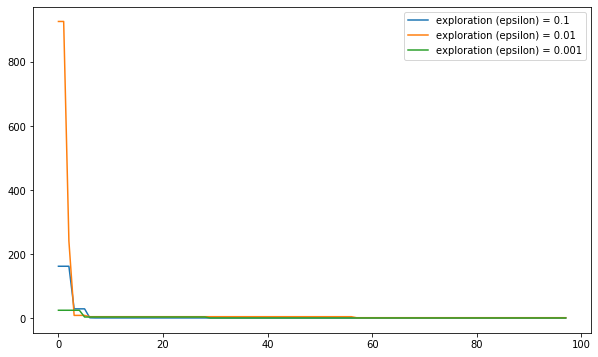

In [185]:
fig = plt.figure(figsize=(10,6))

plt.plot(list(range(n_iter)), squared_error_pi1, label='exploration (epsilon) = 0.1')
plt.plot(list(range(n_iter)), squared_error_pi2, label='exploration (epsilon) = 0.01')
plt.plot(list(range(n_iter)), squared_error_pi3, label='exploration (epsilon) = 0.001')

plt.legend()
plt.show()